# Preprocessing

## Import all necessary Library

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Read file

In [ ]:
np.set_printoptions(suppress=True, precision=20, threshold=10, linewidth=40)  # np forbids scientific counting
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # pd forbids scientific counting

In [ ]:
path = "data/train_data.csv"

df_all = pd.read_csv(path)  # 读取数据，根据你自己文件地址编写

df_all.drop_duplicates(inplace=True)  # 使用drop_duplicates去重，inplace=True对原数据集进行替换
df_all.reset_index(drop=True, inplace=True)  # 删除数据后，恢复索引

df_all

In [ ]:
# 整体查看数据类型 以及缺失情况
df_all.info()

In [ ]:
df_all['Hospital_code'] = df_all['Hospital_code'].astype(object)
df_all['City_Code_Hospital'] = df_all['City_Code_Hospital'].astype(object)
df_all['Bed Grade'] = df_all['Bed Grade'].astype(object)
df_all['City_Code_Patient'] = df_all['City_Code_Patient'].astype(object)
df_all['Hospital_code'] = df_all['Hospital_code'].astype(float)
df_all['Available Extra Rooms in Hospital'] = df_all['Available Extra Rooms in Hospital'].astype(float)
df_all['patientid'] = df_all['patientid'].astype(float)
df_all['Visitors with Patient'] = df_all['Visitors with Patient'].astype(float)

In [ ]:
df_all.info()

In [ ]:
# 定义查找缺失变量函数，返回 缺失值率> 指定缺失率(narate) 的列表
def filter_col_by_nan(data, narate=0.2):
    '''
    :param data: 查找数据集
    :param narate: 设定变量的缺失值率
    :return: 返回 缺失率>narate的变量名称列表
    '''
    n_samples = data.shape[0]
    list_nan_cols = []
    for col in data.columns:
        if data[col].isna().sum() / n_samples >= (narate):
            list_nan_cols.append(col)

    print(f'缺失量在{narate * 100}%以上的变量有:{list_nan_cols}')

    return list_nan_cols


list_nullfactor_todrop = filter_col_by_nan(df_all, narate=0.3)

df_select = df_all.drop(list_nullfactor_todrop, axis=1).copy()
df_select

## Data analysis

### Distribution of numeric independent variables

In [ ]:


# plt.figure(figsize=(15, 8))
#
# df_select.drop('Stay', axis=1).hist()
# plt.tight_layout()
# plt.show()
#
# print('Skewness:')
# df_select.drop('Stay', axis=1).skew()

In [ ]:
import seaborn as sns

### Univariate Analysis

In [ ]:
df_select['Stay'].replace('More than 100 Days', '>100', inplace=True)

for i in ['Stay', 'Department', 'Available Extra Rooms in Hospital', 'Ward_Type', 'Ward_Facility_Code', 'Age',
          'Type of Admission', 'Severity of Illness', 'Bed Grade', 'Hospital_region_code', 'Hospital_type_code',
          'City_Code_Hospital', 'Hospital_code', 'City_Code_Patient', 'Visitors with Patient']:
    count = df_select[i].value_counts()

    plt.figure(figsize=(10, 5))

    sns.barplot(x=count.index.values, y=count.values, data=df_select)

    plt.xlabel(i)
    plt.ylabel('No of occurences')

### Bivariate Analysis

In [ ]:

for i in ['Department', 'Ward_Type', 'Ward_Facility_Code', 'Age', 'Type of Admission', 'Severity of Illness',
          'Bed Grade', 'Hospital_region_code', 'Hospital_type_code']:
    plt.figure(figsize=(10, 5))

    sns.countplot(x='Stay', hue=i, data=df_select)

### Numerical Features

In [ ]:
sns.distplot(df_select['Admission_Deposit'])

## Missing values

In [ ]:
df_select.isnull().sum()

In [ ]:
def impute_missing_values(data, columns):
    for column in columns:
        data[column] = data[column].fillna(data[column].value_counts().index[0])
        print(data[column].value_counts().index[0])

In [ ]:
impute_columns = ['Bed Grade', 'City_Code_Patient']

impute_missing_values(df_select, impute_columns)

In [ ]:

df_select.isnull().sum()

## Encoding

In [ ]:
admission_encode = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
severity_encode = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

df_select['Type of Admission'] = df_select['Type of Admission'].map(admission_encode)
df_select['Severity of Illness'] = df_select['Severity of Illness'].map(severity_encode)

df_select['Age'] = df_select['Age'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10})

df_select['Stay'] = df_select['Stay'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10, '>100': 11})

# df_cat_train['Stay'] = df_cat_train['Stay'].astype(int)

In [ ]:
sequence_columns = ['Available Extra Rooms in Hospital', 'Bed Grade', 'Visitors with Patient', 'Admission_Deposit', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']
onehot_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code']
other_columns = ['Hospital_code', 'City_Code_Hospital', 'patientid', 'City_Code_Patient']

def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)

    return data

In [ ]:
df_select

In [ ]:

data = onehot_encode(df_select, onehot_columns)
data

In [ ]:
# sns.heatmap(data.corr(), annot=True)

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data.set_index('case_id', inplace=True)

y = data['Stay']
X = data.drop(['Stay'], axis=1)

In [ ]:
y

In [ ]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [ ]:
X

## Split dataset

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [ ]:
# X = sm.add_constant(X)
X_all = X
Y_all = y
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, random_state=10, test_size=0.2)

In [ ]:
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)
print(X_all.shape)
print(Y_all.shape)

In [ ]:
Xtrain

In [ ]:
Ytrain

In [ ]:
# K Fold Cross Validation
# from sklearn.model_selection import KFold,cross_val_score
# kfold=KFold(n_splits=10, shuffle=True, random_state=10)

## Feature Selection

In [302]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

In [303]:
# 1.构建RF模型
RFC_ = RFC()  # 随机森林
RFC_ = KNN()  # KNN

In [304]:
# c = RFC_.fit(Xtrain, Ytrain).feature_importances_  # 特征重要性
# print("重要性：")
# c

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [ ]:
# # 2. 交叉验证递归特征消除法
# selector = RFECV(RFC_, step=1, cv=10)  # 采用交叉验证，每次排除一个特征，筛选出最优特征
# selector = selector.fit(Xtrain, Ytrain)
# X_wrapper = selector.transform(Xtrain)  # 最优特征
# score = cross_val_score(RFC_, X_wrapper, Ytrain, cv=10).mean()  # 最优特征分类结果
# print(score)
# print("最佳数量和排序")
# print(selector.support_)  # 选取结果
# print(selector.n_features_)  # 选取特征数量
# print(selector.ranking_)  # 依次排数特征排序

In [ ]:
# print(score)
# print("最佳数量和排序")
# selector.support_  # 选取结果

In [305]:
# 3.递归特征消除法
selector1 = RFE(RFC_, n_features_to_select=0.5, step=1).fit(Xtrain,
                                                            Ytrain)  # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征

ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:

selector1.support_.sum()
print(selector1.ranking_)  # 特征排除排序
print(selector1.n_features_)  # 选择特征数量
X_wrapper1 = selector1.transform(Xtrain)  # 最优特征
score = cross_val_score(RFC_, X_wrapper1, Ytrain, cv=3).mean()
score

In [ ]:
selector1.n_features_  # 选取特征数量

In [ ]:
selector1.ranking_

In [ ]:
support_cat_list = selector1.support_

In [ ]:
support_cat_list = [True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    True,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    True,
                    True,
                    True,
                    False,
                    False,
                    True,
                    True,
                    True,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    False,
                    True]
support_cat_list

In [ ]:
# # 4.递归特征消除法和曲线图选取最优特征数量
# score = []  # 建立列表
# for i in range(1, 17, 1):
#     X_wrapper = RFE(RFC_, n_features_to_select=i, step=1).fit_transform(Xtrain, Ytrain)  # 最优特征
#     once = cross_val_score(RFC_, X_wrapper, Ytrain, cv=9).mean()  # 交叉验证
#     score.append(once)  # 交叉验证结果保存到列表
# print(max(score), (score.index(max(score)) * 1) + 1)  # 输出最优分类结果和对应的特征数量
# print(score)
# plt.figure(figsize=[20, 5])
# plt.plot(range(1, 17, 1), score)
# plt.xticks(range(1, 17, 1))
# plt.show()

In [ ]:
# RFE.ranking_

In [ ]:
columns_list = list(Xtrain.columns)

In [ ]:
list_factor_todrop = []
for i in range(38):
    if support_cat_list[i] is False:
        list_factor_todrop.append(columns_list[i])

list_factor_todrop  #需要抛弃的变量

In [ ]:
Xtrain.drop(list_factor_todrop, axis=1, inplace=True)
Xtest.drop(list_factor_todrop, axis=1, inplace=True)
X_all.drop(list_factor_todrop, axis=1, inplace=True)

In [ ]:

Xtrain_remove_other = Xtrain.drop(other_columns, axis=1)
Xtest_remove_other = Xtest.drop(other_columns, axis=1)


In [ ]:
Xtrain

In [ ]:
Xtrain_remove_other

In [ ]:
Ytrain

# Train and Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion='entropy', random_state=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)
accuracy_score(Ytest, y_pred_DT) * 100

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Ytest, y_pred_DT))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_DT, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Decision Tree with HyperParameter adjustment

In [ ]:
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV

paramGrid = dict(
    max_depth=range(15),
    criterion=["gini", "entropy"])
dtModel = DecisionTreeClassifier(random_state=10)
grid = GridSearchCV(dtModel, paramGrid, cv=10, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [ ]:
print(grid.best_params_)

In [298]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion='gini', random_state=10, max_depth=10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT = decision_tree.predict(Xtest)
accuracy_score(Ytest, y_pred_DT) * 100

33.60915714106268

In [299]:
print(classification_report(Ytest, y_pred_DT))

              precision    recall  f1-score   support

           1       0.30      0.07      0.12      4805
           2       0.33      0.54      0.41     15569
           3       0.37      0.56      0.44     17460
           4       0.25      0.09      0.14     11083
           5       0.07      0.00      0.00      2321
           6       0.27      0.20      0.23      6944
           7       1.00      0.00      0.01       545
           8       0.21      0.01      0.02      2073
           9       0.27      0.02      0.03      1010
          10       0.19      0.01      0.02       562
          11       0.45      0.34      0.39      1316

    accuracy                           0.34     63688
   macro avg       0.34      0.17      0.16     63688
weighted avg       0.31      0.34      0.29     63688



In [300]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_DT, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

0.8106465262742595

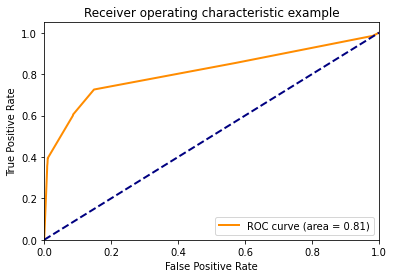

In [301]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [306]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(random_state=10)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest, y_pred_RF) * 100

39.74689109408366

In [307]:
print(classification_report(Ytest, y_pred_RF))

              precision    recall  f1-score   support

           1       0.33      0.17      0.22      4805
           2       0.39      0.46      0.43     15569
           3       0.41      0.57      0.48     17460
           4       0.36      0.26      0.31     11083
           5       0.10      0.01      0.02      2321
           6       0.40      0.49      0.44      6944
           7       0.25      0.01      0.03       545
           8       0.34      0.09      0.14      2073
           9       0.44      0.19      0.26      1010
          10       0.53      0.07      0.12       562
          11       0.59      0.47      0.52      1316

    accuracy                           0.40     63688
   macro avg       0.38      0.25      0.27     63688
weighted avg       0.38      0.40      0.37     63688



In [308]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_RF, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

0.8990311001916729

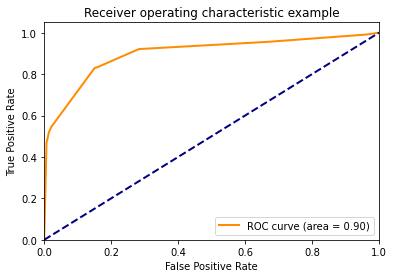

In [309]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Random Forest with HyperParameter adjustment

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

paramGrid = dict(
    n_estimators=np.linspace(10, 100, 10).astype(int),
    max_depth=np.arange(4, 11))
rfModel = RandomForestClassifier(random_state=10)
grid = GridSearchCV(rfModel, paramGrid, cv=10, return_train_score=True)
grid.fit(Xtrain, Ytrain)
print(grid.best_params_)

In [ ]:
rf_classification = RandomForestClassifier(random_state=10, max_depth=10, n_estimators=100)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest, y_pred_RF) * 100

In [ ]:
print(classification_report(Ytest, y_pred_RF))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_RF, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [ ]:
# from mlxtend.classifier import LogisticRegression as LR
# from sklearn.metrics import accuracy_score

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
#
# paramGrid = dict(
#     penalty=['l1', 'l2'],
#     C=[0.1, 1, 10, 100, 1000])
# lrModel = LogisticRegression(random_state=10)
# grid = GridSearchCV(lrModel, paramGrid, cv=3, return_train_score=True)
# grid.fit(Xtrain, Ytrain)
# print(grid.best_params_)

In [ ]:
# LR = LogisticRegression(fit_intercept=True, C=10, penalty="l2")
#
# LR.fit(Xtrain, Ytrain)
#
# y_pred_LR = LR.predict(Xtest)
# accuracy_score(Ytest, y_pred_LR) * 100

In [ ]:
# print(classification_report(Ytest, y_pred_LR))

In [ ]:
# from sklearn import metrics
#
# fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_LR, pos_label=11)
# auc = metrics.auc(fpr, tpr)
# auc

In [ ]:
# import matplotlib.pyplot as plt
#
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

## Gradient boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=10)

GB.fit(Xtrain, Ytrain)
y_pred_GB = GB.predict(Xtest)
accuracy_score(Ytest, y_pred_GB) * 100

In [ ]:
print(classification_report(Ytest, y_pred_GB))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_GB, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(Xtrain_remove_other, Ytrain)

y_pred_NB = NB.predict(Xtest_remove_other)
accuracy_score(Ytest, y_pred_NB) * 100

In [ ]:
print(classification_report(Ytest, y_pred_NB))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_NB, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Xtest_remove_other

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
Xtrain_num = Xtrain_remove_other[['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']]
Xtrain_cat = Xtrain_remove_other.drop(['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'], axis=1)
Xtest_num = Xtest_remove_other[['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit']]
Xtest_cat = Xtest_remove_other.drop(['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'], axis=1)
kbs = KBinsDiscretizer(n_bins=5, encode='onehot').fit(Xtrain_num)

Xtrain_cat

In [ ]:
Xtrain_num

In [ ]:
Xtrain_num_1 = pd.cut(Xtrain_num['Available Extra Rooms in Hospital'], 5, labels=False)
Xtrain_num_2 = pd.cut(Xtrain_num['Visitors with Patient'], 5, labels=False)
Xtrain_num_3 = pd.cut(Xtrain_num['Admission_Deposit'], 5, labels=False)

Xtest_num_1 = pd.cut(Xtest_num['Available Extra Rooms in Hospital'], 5, labels=False)
Xtest_num_2 = pd.cut(Xtest_num['Visitors with Patient'], 5, labels=False)
Xtest_num_3 = pd.cut(Xtest_num['Admission_Deposit'], 5, labels=False)

Xtrain_NB = pd.merge(Xtrain_num_1, Xtrain_num_2, left_index=True, right_index=True)
Xtrain_NB = pd.merge(Xtrain_NB, Xtrain_num_3, left_index=True, right_index=True)

Xtest_NB = pd.merge(Xtest_num_1, Xtest_num_2, left_index=True, right_index=True)
Xtest_NB = pd.merge(Xtest_NB, Xtest_num_3, left_index=True, right_index=True)

In [ ]:
Xtrain_NB

In [ ]:
Xtest_NB

In [ ]:
Xtrain_NB = pd.DataFrame(scaler.fit_transform(Xtrain_NB), index=Xtrain_NB.index, columns=Xtrain_NB.columns)
Xtest_NB = pd.DataFrame(scaler.fit_transform(Xtest_NB), index=Xtest_NB.index, columns=Xtest_NB.columns)

In [ ]:
Xtrain_NB

In [ ]:
Xtrain_cat

In [ ]:
Xtrain_NB = pd.merge(Xtrain_NB, Xtrain_cat, left_index=True, right_index=True)
Xtest_NB = pd.merge(Xtest_NB, Xtest_cat, left_index=True, right_index=True)

In [ ]:
Xtrain_NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(Xtrain_NB, Ytrain)

In [ ]:
y_pred_NB = mnb.predict(Xtest_NB)

In [ ]:
accuracy_score(Ytest, y_pred_NB) * 100

## KNN with HyperParameter adjustment

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

paramGrid = dict(
    n_neighbors=[10, 50, 300, 500, 1000],
    weights=["uniform", "distance"])
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, paramGrid, cv=3, return_train_score=True)
grid.fit(Xtrain_remove_other, Ytrain)
print(grid.best_params_)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=300, weights='distance')
knn.fit(Xtrain_remove_other, Ytrain)
y_pred_KNN = knn.predict(Xtest_remove_other)
accuracy_score(Ytest, y_pred_KNN) * 100

In [ ]:
print(classification_report(Ytest, y_pred_NB))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, y_pred_KNN, pos_label=11)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## CATBoost

In [ ]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(random_state=10, use_best_model=True, iterations=1000)
cb.fit(Xtrain, Ytrain, use_best_model=True, verbose=100, eval_set=(Xtest, Ytest))

In [ ]:
cb_pred_test = cb.predict(Xtest)
accuracy_score(Ytest, cb_pred_test) * 100

In [ ]:
print(classification_report(Ytest, cb_pred_test))

In [ ]:
cb_pred_train = cb.predict(Xtrain)
accuracy_score(Ytrain, cb_pred_train) * 100

In [ ]:
print(classification_report(Ytrain, cb_pred_train))

In [ ]:
cb_pred_all = cb.predict(X_all)
accuracy_score(Y_all, cb_pred_all) * 100

In [ ]:
print(classification_report(Y_all, cb_pred_all))

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Ytest, cb_pred_all, pos_label=2)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()